In [9]:
pip install prophet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 34.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.4 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [28]:
import pandas as pd
import numpy as np
from prophet import Prophet
from prophet.make_holidays import make_holidays_df
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt

In [29]:
df = pd.read_csv("/Users/naveenapaleti/Projects/ShopTrack360/data/cleaned_ecommerce_data.csv")
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df["TotalPrice"] = df["Quantity"] * df["UnitPrice"]

In [37]:
# Aggregate to daily revenue
daily_revenue = df.groupby(df['InvoiceDate'].dt.date)['TotalPrice'].sum().reset_index()
daily_revenue.columns = ['ds', 'y'] 

In [38]:
daily_revenue.to_csv("/Users/naveenapaleti/Projects/ShopTrack360/data/daily_sales_summary.csv", index=False)

In [39]:
model = Prophet()
model.fit(daily_revenue)

20:36:16 - cmdstanpy - INFO - Chain [1] start processing
20:36:16 - cmdstanpy - INFO - Chain [1] done processing


In [40]:
# Forecast next 30 days
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

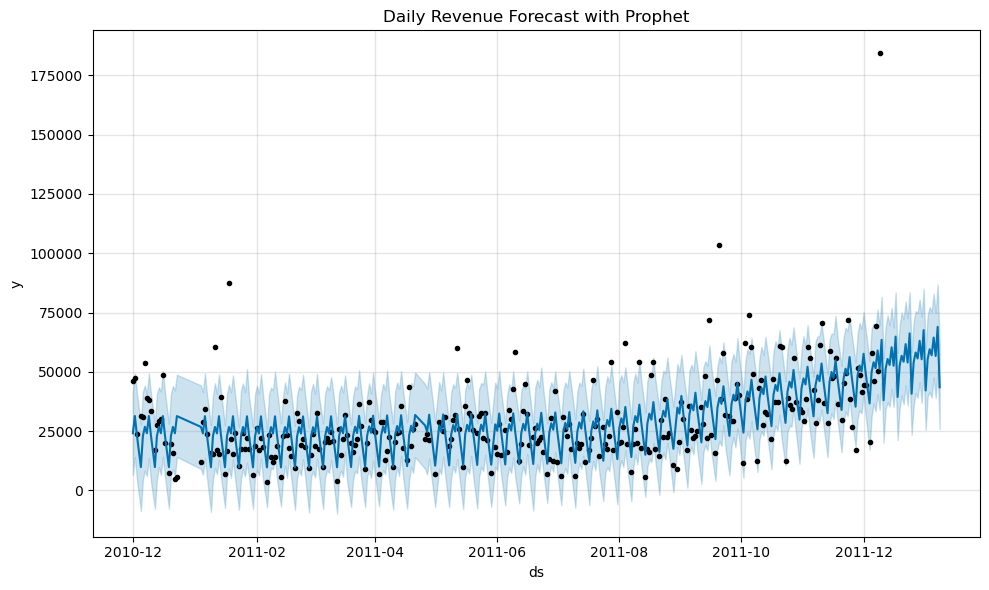

In [41]:
# Plot forecast
model.plot(forecast)
plt.title("Daily Revenue Forecast with Prophet")
plt.tight_layout()
plt.show()

In [42]:
# Initialize Prophet with seasonality + holidays
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False
)
model.add_country_holidays(country_name='UnitedKingdom')


In [43]:
df = df.rename(columns={
    'InvoiceDate': 'ds',         # or use the actual column name for date
    'TotalPrice': 'y'            # or use the column with your sales/revenue
})

In [44]:
# Fit the model
model.fit(df)

# Forecast 30 days ahead
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)

20:36:55 - cmdstanpy - INFO - Chain [1] start processing
20:37:00 - cmdstanpy - INFO - Chain [1] done processing


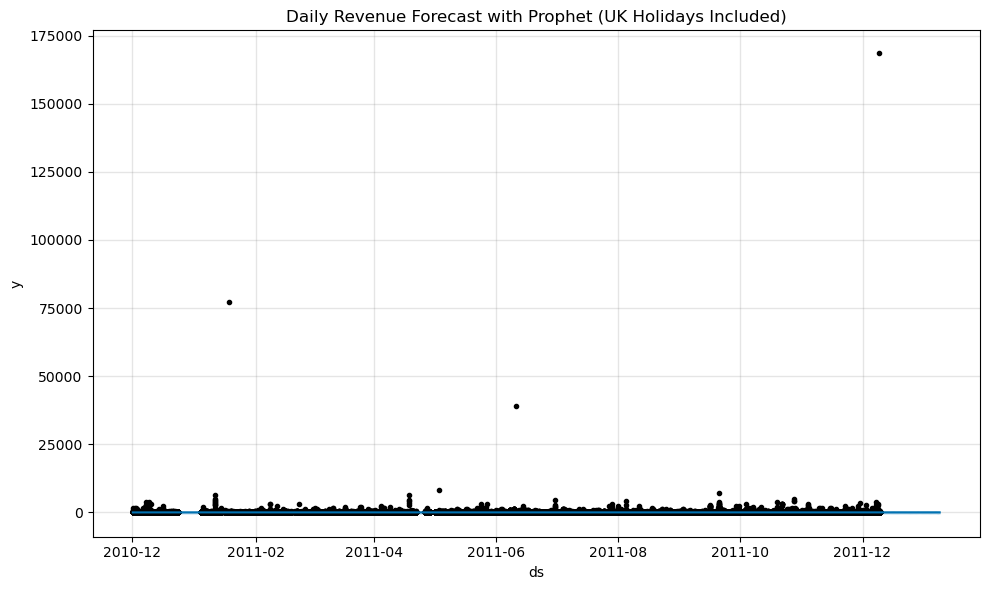

In [45]:
# Plot forecast
model.plot(forecast)
plt.title("Daily Revenue Forecast with Prophet (UK Holidays Included)")
plt.tight_layout()
plt.show()

In [46]:
# Ensure datetime index
ts = daily_revenue.set_index('ds')['y']

# Fit ARIMA
model_arima = ARIMA(ts, order=(5,1,2))
result = model_arima.fit()

/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/anaconda3/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


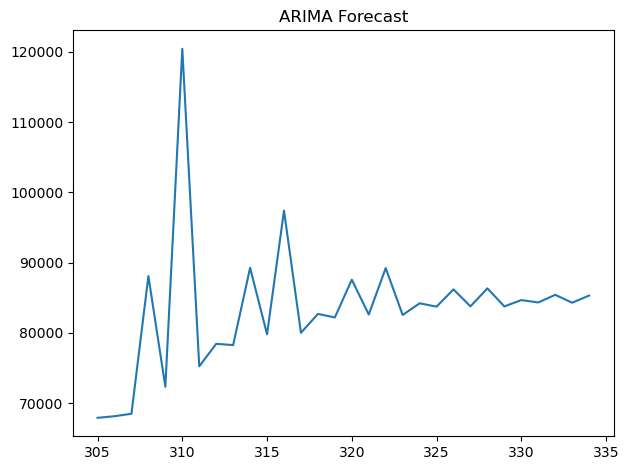

In [47]:
# Forecast
forecast_arima = result.forecast(steps=30)

forecast_arima.plot(title="ARIMA Forecast")
plt.tight_layout()
plt.show()


In [49]:
forecast = model.predict(future)

In [50]:
# y_true: actual values from original df (aligned with forecast)
y_true = df['y'][-30:].values  # Assuming you forecasted 30 days ahead

# y_pred: predicted values from forecast
y_pred = forecast['yhat'][-30:].values

# Calculate metrics
mae = mean_absolute_error(y_true, y_pred)
rmse = np.sqrt(mean_squared_error(y_true, y_pred))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

MAE: 25.07
RMSE: 38.38
